In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from utils.metrics import rel_err, rank_corr, mse_K_part
from nphc3.optim import gradient_g, gradient_g_ij
from numba import autojit

# Load data
- **kernel** should be in [**exp_d100**, **plaw_d10**, **rect_d100**]
- **mode** should be in [**nonsym**, **sym**, **sym_hard**]
- **log10T** should be in [**5**, **6**, **7**, **8**, **9**]

In [2]:
kernel = 'plaw_d10'
mode = 'nonsym'
log10T = 7
url = 'https://s3-eu-west-1.amazonaws.com/nphc-data/{}_{}_log10T{}_with_Beta_without_N.pkl.gz'.format(kernel, mode, log10T)

In [3]:
from utils.loader import load_data
cumul, Beta = load_data(url)

... loading data


# Minimize MSE on full third order integrated cumulant

In [4]:
objective = lambda R: mse_K_part(cumul,R)

from utils.prox import *
from nphc3.optim import inspector, nag, adagrad, adadelta
grad_fun = lambda X: gradient_g(cumul,X)
def grad_fun_ij(R,i,j,k):
    return gradient_g_ij(cumul,R,i,j)

# Nesterov Accelerated Gradient

In [5]:
d = cumul.dim
eta = 1e5
lbd_l1 = 1e-6
lbd_nuc = 1e-6
#n_iter = 1600
n_iter = 3500

In [6]:
#R0_ = np.arange(d**2).reshape(d,d)/(d**2)
R0_ = np.ones((d,d))

nag_inspector = inspector(objective,cumul.R_true,n_iter=n_iter)

#R_nag = nag(R0_,grad_fun,n_iter=n_iter,step=eta,prox=prox_nuclear,lbd=lbd_nuc,callback=nag_inspector)
R_nag = nag(R0_,grad_fun,n_iter=n_iter,step=eta,prox=prox_l1,lbd=lbd_l1,callback=nag_inspector)
#R_nag = nag(R0_,grad_fun,n_iter=n_iter,step=eta,prox=prox_zero,lbd=lbd_l1,callback=nag_inspector)

### Plot objective over time

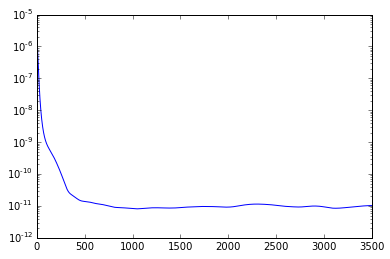

In [7]:
plt.plot(nag_inspector.obj)
plt.yscale('log')

### Plot relative error over time

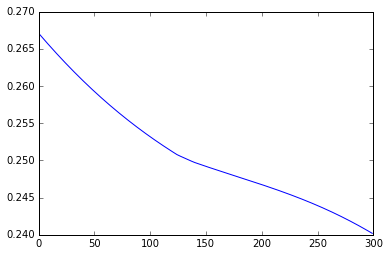

In [8]:
plt.plot(nag_inspector.err)

In [9]:
print(rel_err(cumul.R_true,np.zeros((d,d))))
print(rel_err(cumul.R_true,R_nag))

0.3
0.212198896286


# AdaGrad

In [10]:
d = cumul.dim
eta = 1e0
lbd_l1 = 1e-5
lbd_nuc = 1e-5
n_iter = 100000
#n_iter = 1600

In [11]:
#R0_ = np.arange(d**2).reshape(d,d)/(d**2)
R0_ = np.ones((d,d))

adagrad_inspector = inspector(objective,cumul.R_true,n_iter=n_iter)

#R_adagrad = adagrad(R0_,grad_fun_ij,n_iter=n_iter,step=eta,prox=prox_nuclear,lbd=lbd_nuc,callback=adagrad_inspector)
R_adagrad = adagrad(R0_,grad_fun_ij,n_iter=n_iter,step=eta,prox=prox_l1,lbd=lbd_l1,callback=adagrad_inspector)
#R_adagrad = adagrad(R0_,grad_fun_ij,n_iter=n_iter,step=eta,prox=prox_zero,lbd=lbd_l1,callback=adagrad_inspector)

### Plot objective over time

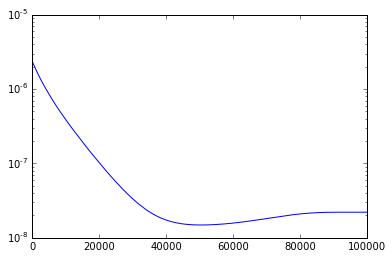

In [12]:
plt.plot(adagrad_inspector.obj)
plt.yscale('log')

### Plot relative error over time

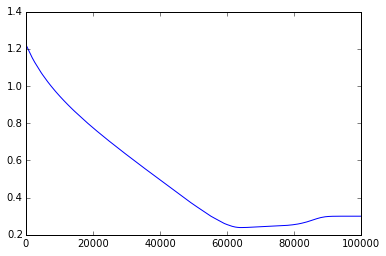

In [13]:
plt.plot(adagrad_inspector.err)

In [14]:
print(rel_err(cumul.R_true,np.zeros((d,d))))
print(rel_err(cumul.R_true,R_adagrad))

0.3
0.3


# AdaDelta

In [15]:
gamma = 0.95
eps = 1e-4
lbd_l1 = 1e-7
lbd_nuc = 1e-7
n_iter = 1000000
#n_iter = 1600

In [16]:
R0_ = np.arange(d**2).reshape(d,d)/(d**2)
#R0_ = np.ones((d,d))

adadelta_inspector = inspector(objective,cumul.R_true,n_iter=n_iter)

#R_adadelta = adadelta(R0_,grad_fun_ij,gamma=gamma,eps=eps,n_iter=n_iter,prox=prox_nuc,lbd=lbd_nuc,callback=adadelta_inspector)
R_adadelta = adadelta(R0_,grad_fun_ij,gamma=gamma,eps=eps,n_iter=n_iter,prox=prox_l1,lbd=lbd_l1,callback=adadelta_inspector)
#R_adadelta = adadelta(R0_,grad_fun_ij,gamma=gamma,eps=eps,n_iter=n_iter,prox=prox_zero,lbd=lbd_l1,callback=adadelta_inspector)

### Plot objective over time

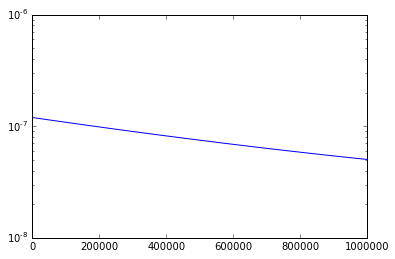

In [17]:
plt.plot(adadelta_inspector.obj)
plt.yscale('log')

### Plot relative error over time

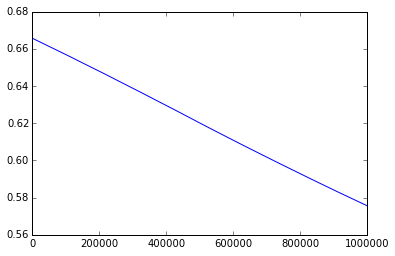

In [18]:
plt.plot(adadelta_inspector.err)

In [19]:
print(rel_err(cumul.R_true,np.zeros((d,d))))
print(rel_err(cumul.R_true,R_adadelta))

0.3
0.575612783271


# Heatmaps

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


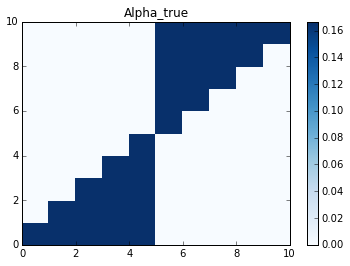

In [20]:
from scipy.linalg import inv
Alpha_true = np.eye(d) - inv(cumul.R_true)
Alpha_pred = np.eye(d) - inv(R_nag)
#Alpha_pred = np.eye(d) - inv(R_adagrad)
#Alpha_pred = np.eye(d) - inv(R_adadelta)

plt.pcolor(Alpha_true,cmap=plt.cm.Blues)
plt.title("Alpha_true")
plt.colorbar()
plt.show()
plt.close()

0.21219701763
0.417055683327


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


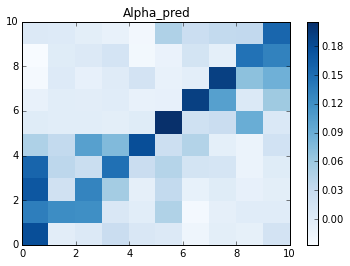

In [21]:
print(rel_err(Alpha_true,Alpha_pred))
_, s, _ = np.linalg.svd(Alpha_pred)
print(s.max())

#Alpha_pred[Alpha_pred <= 0.] = 0.

plt.pcolor(Alpha_pred,cmap=plt.cm.Blues)
plt.title("Alpha_pred")
plt.colorbar()
plt.show()
plt.close()

In [22]:
print(rel_err(Alpha_true,Alpha_pred))

0.21219701763


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


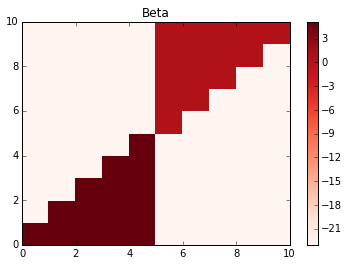

In [23]:
plt.pcolor(np.log(1e-10+Beta),cmap=plt.cm.Reds)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()